In [69]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import davies_bouldin_score, silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

Loading the dataset

In [70]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')

Creating a unique table out the existing to get each unique customer details right and their total history

In [71]:
customer_transactions = transactions.groupby('CustomerID').agg(
    TotalValue=('TotalValue', 'sum'),
    TotalQuantity=('Quantity', 'sum'),
    AvgPrice=('Price', 'mean')
).reset_index()

In [112]:
customer_transactions.head()

,CustomerID,TotalValue,TotalQuantity,AvgPrice
0,C0001,3354.52,12,278.334000
1,C0002,1862.74,10,208.920000
2,C0003,2725.38,14,195.707500
3,C0004,5354.88,23,240.636250
4,C0005,2034.24,7,291.603333


Left join on customer table and new customer transaction table to get updated data of each customer.

In [114]:
customer_profiles = customers.merge(customer_transactions, on='CustomerID', how='left')
customer_profiles.fillna(0, inplace=True)

Converting each data type to string to do processing in the later stage.

In [117]:
customer_profiles = customer_profiles.convert_dtypes()

In [118]:
customer_profiles.head()

,CustomerID,CustomerName,Region,SignupDate,TotalValue,TotalQuantity,AvgPrice
0,C0001,Lawrence Carroll,South America,2022-07-10,3354.52,12,278.334
1,C0002,Elizabeth Lutz,Asia,2022-02-13,1862.74,10,208.92
2,C0003,Michael Rivera,South America,2024-03-07,2725.38,14,195.7075
3,C0004,Kathleen Rodriguez,South America,2022-10-09,5354.88,23,240.63625
4,C0005,Laura Weber,Asia,2022-08-15,2034.24,7,291.603333


In [119]:
encoder = OneHotEncoder(sparse_output=False, drop='first')
region_encoded = encoder.fit_transform(customer_profiles[['Region']])
region_encoded_df = pd.DataFrame(region_encoded, columns=encoder.get_feature_names_out(['Region']))


In [120]:
features = pd.concat(
    [customer_profiles[['TotalValue', 'TotalQuantity', 'AvgPrice']].reset_index(drop=True),
     region_encoded_df.reset_index(drop=True)], axis=1
)

In [121]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

Get numeric value of each desired features for passing it to the model.

In [122]:
features_scaled

array([[-0.05188436, -0.1107351 ,  0.11036581, -0.57735027, -0.54653573,
         1.54590766],
       [-0.86271433, -0.43404927, -0.85462643, -0.57735027, -0.54653573,
        -0.64686916],
       [-0.393842  ,  0.21257907, -1.03830637, -0.57735027, -0.54653573,
         1.54590766],
       ...,
       [-1.36869358, -1.56564887, -0.42665388,  1.73205081, -0.54653573,
        -0.64686916],
       [-0.79937112, -0.59570636, -0.27505276,  1.73205081, -0.54653573,
        -0.64686916],
       [ 0.71127787,  0.53589324,  0.36299264, -0.57735027, -0.54653573,
        -0.64686916]])

Trying Agglomerative Clustering for experimental purpose and tried values from 2 to 10 and got the best result here.

In [103]:
agg_clustering = AgglomerativeClustering(n_clusters=10)
agg_clustering.fit(features_scaled)


labels = agg_clustering.labels_

db_index = davies_bouldin_score(features_scaled,labels)
print(db_index)
silhouette_avg_agg = silhouette_score(features_scaled, labels)
print(silhouette_avg_agg)

0.93709137713604
0.35945650795960987


Here I tried to use K Means Clustering algorithm for clustering each data points in to number of clusters.

In [123]:
inertia = []
k_range = range(2, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

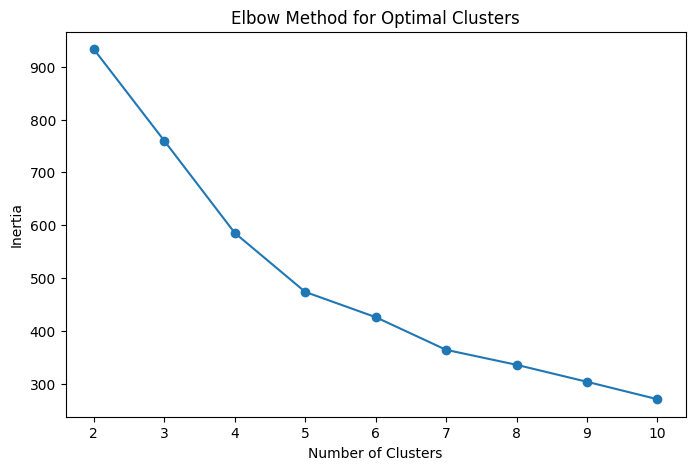

In [124]:
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

The best results are delivered at clusters = 10, where DB-Index is 0.93 and Silhouette Score = 0.37

In [101]:
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(features_scaled)

customer_profiles['Cluster'] = cluster_labels

db_index = davies_bouldin_score(features_scaled, cluster_labels)
silhouette_avg = silhouette_score(features_scaled, cluster_labels)

In [125]:
print(f'Number of Clusters: {optimal_k}')
print(f'DB Index: {db_index}')
print(f'Silhouette Score: {silhouette_avg}')

Number of Clusters: 10
DB Index: 0.93709137713604
Silhouette Score: 0.36728575287932785


Here we've used PCA for reducing the dimension of the data and visualising it in 2D.

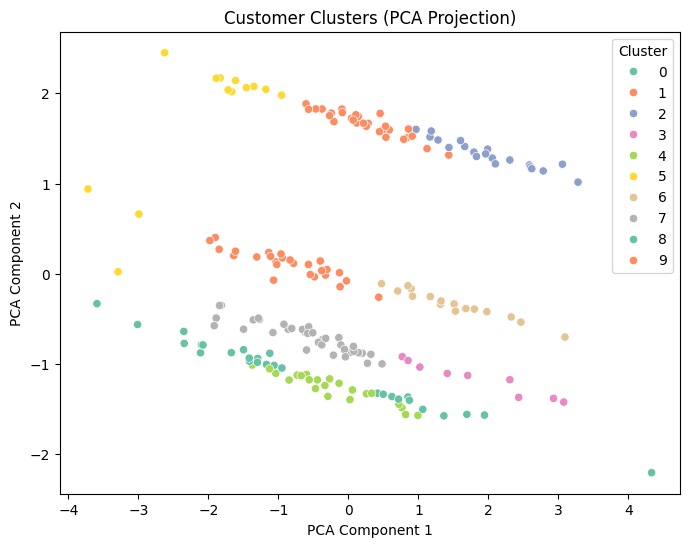

In [126]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=cluster_labels, palette='Set2')
plt.title('Customer Clusters (PCA Projection)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')

plt.legend(title='Cluster', loc='upper right')
plt.show()